# Demonstration of SDC Convergence

In [3]:
%matplotlib inline
import riesling as rl
os=1.3
recon_settings=f'--kernel=KB3 --os={os}'

First generate our phantom. We heavily undersample radially (with `--nex`) in order to emphasise the problem. Note that this will make the _correct_ reconstructions very blurry - we are not acquiring a sufficient amount of data at high spatial frequencies to reconstruct the image with precision.

In [4]:
!riesling phantom --fov=192 --matrix=96 --shepp_logan --channels=4 \
  'phantom.h5' --nthreads=16 --os={os} --nex=0.25

First, show the trajectory and reconstruct the image with no density compensation to illustrate why we need it with 3D radial. Note the central part of k-space is massively overweighted, leading to low spatial frequences overwhelming the image.

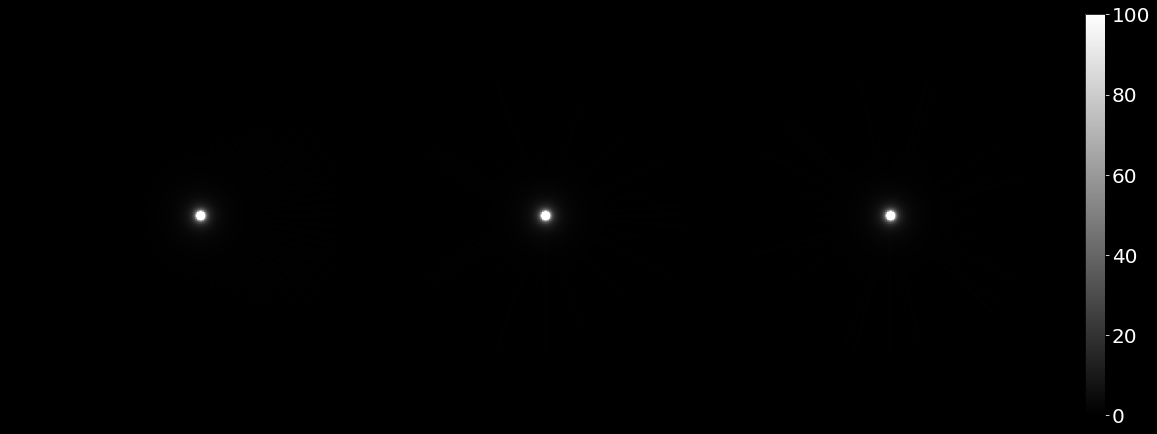

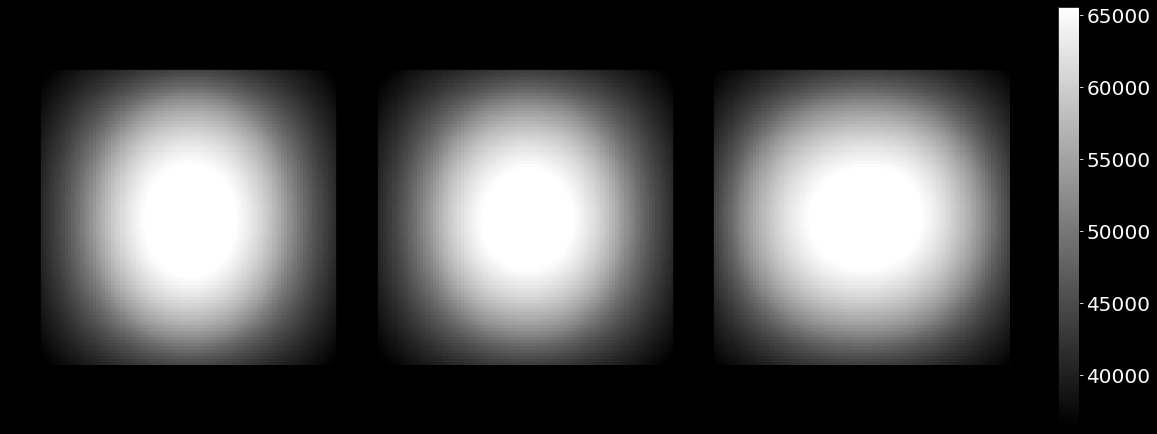

In [5]:
!riesling traj 'phantom.h5' --sdc=none {recon_settings} -o no-sdc
display(rl.images.single('no-sdc-traj.h5', dset='traj-image', clim=[0,100]))
!riesling recon 'phantom.h5' --sdc=none {recon_settings} -o no-sdc
display(rl.images.single('no-sdc-recon.h5', dset='image'))

Now, we repeat the same with analytic radial weights. Note that there is a 'halo' where k-space transitions from fully-sampled to under-sampled. This means that although we do get a reconstruction that actually looks like a phantom, some spatial frequencies are still over-emphasised, which leads to some odd ringing like artefacts at the edge of the phantom.

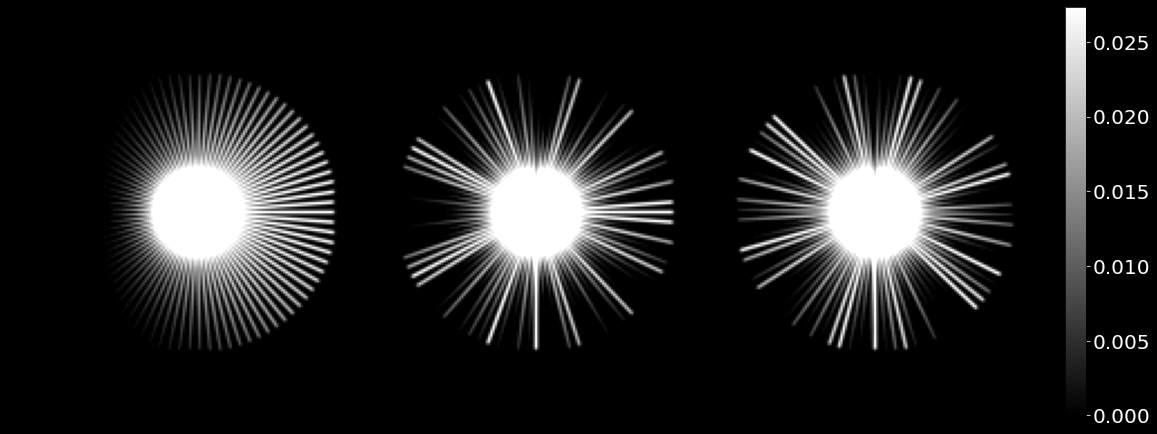

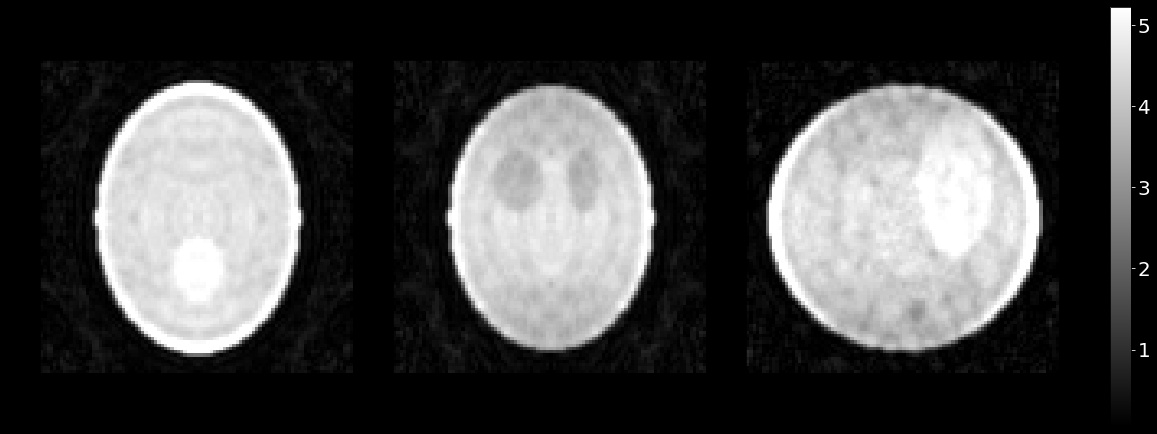

In [9]:
!riesling sdc 'phantom.h5' --sdc=radial
!riesling traj 'phantom.h5' --sdc=phantom-sdc.h5 {recon_settings} -o radial
display(rl.images.single('radial-traj.h5', dset='traj-image'))
!riesling recon 'phantom.h5' --sdc=phantom-sdc.h5 {recon_settings} -o radial
display(rl.images.single('radial-recon.h5', dset='image'))

Next we use Pipe's method (http://doi.wiley.com/10.1002/mrm.23041) with the specific kernel as described in the paper. This is an iterative method to estimate the density of _any_ trajectory, not just radial, and also deals elegantly with undersampling and multiple k-spaces (e.g. WASPI). It is the default method in `riesling`, but we pass `--sdc=pipe` here to make it explicit. The trajectory density is now much flatter and the reconstructed image, although low quality due to the undersampling, does not have any major artefacts. However, as currently implemented the result does not conver to a density of one in undersampled regions of k-space as it should.

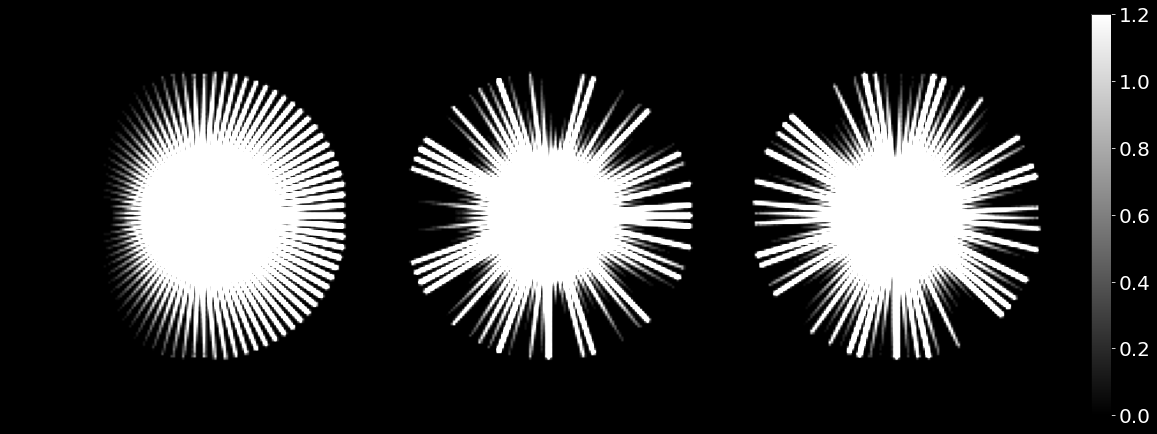

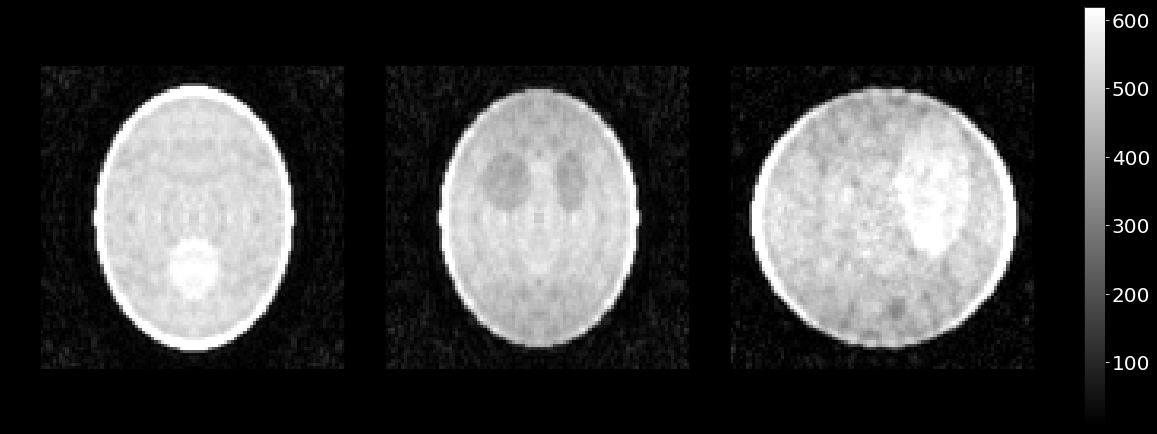

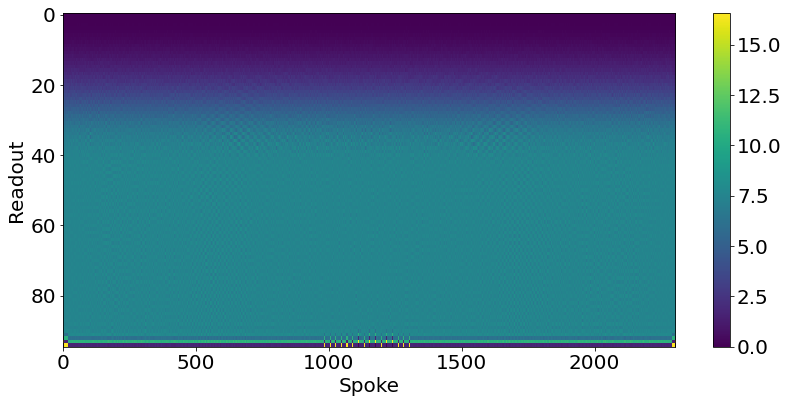

In [7]:
# !riesling sdc 'phantom.h5' -o pipe
!riesling traj 'phantom.h5' --sdc=pipe-sdc.h5 {recon_settings} -o pipe
display(rl.images.single('pipe-traj.h5', dset='traj-image', clim=[0,1.2]))
!riesling recon 'phantom.h5' --sdc=pipe-sdc.h5 {recon_settings} -o pipe
display(rl.images.single('pipe-recon.h5', dset='image'))
display(rl.plots.sdc('pipe-sdc.h5'))

Finally, let's take a look at the Pipe method, but using nearest-neighbour gridding with the oversampling factor of the main reconstruction. This does over-weight some grid points where two samples fall into the same k-space voxel, but it converges to the correct unity weighting once the spokes become undersampled.

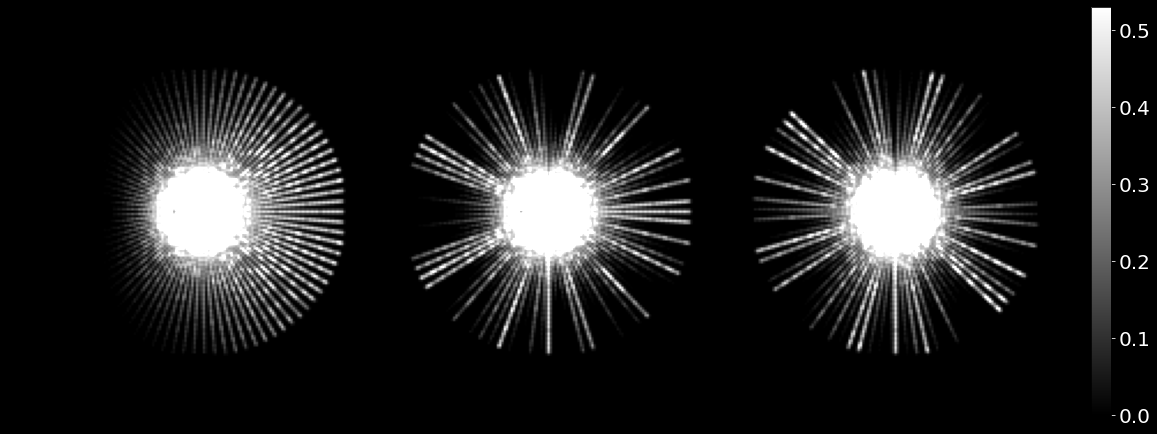

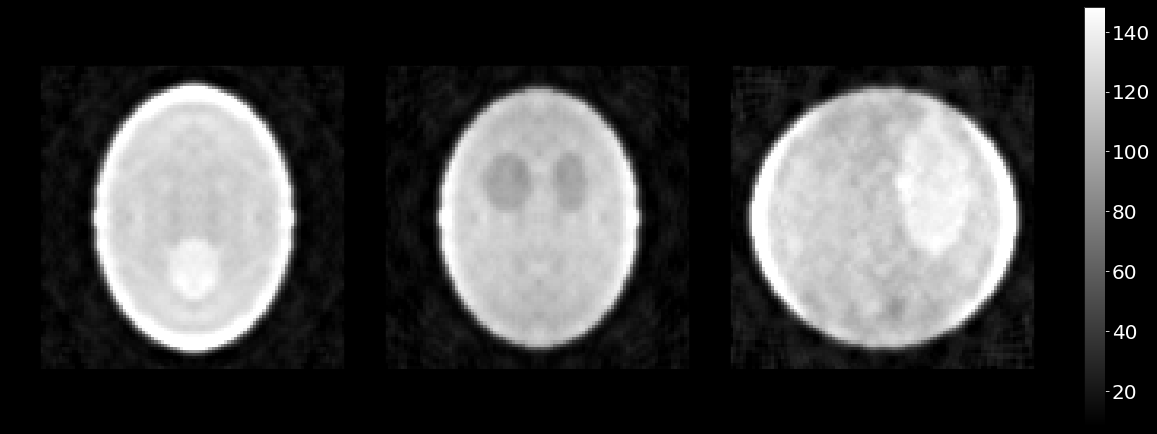

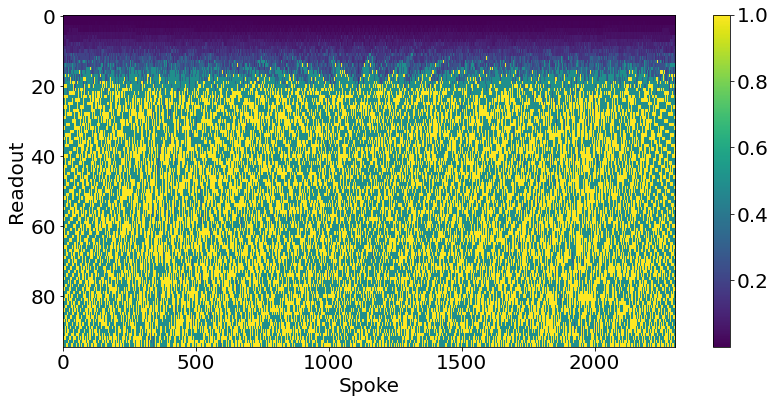

In [8]:
!riesling sdc 'phantom.h5' -o pipenn --sdc=pipenn --os={os}
!riesling traj 'phantom.h5' --sdc=pipenn-sdc.h5 {recon_settings} -o pipenn
display(rl.images.single('pipenn-traj.h5', dset='traj-image'))
!riesling recon 'phantom.h5' --sdc=pipenn-sdc.h5 {recon_settings} -o pipenn
display(rl.images.single('pipenn-recon.h5', dset='image'))
display(rl.plots.sdc('pipenn-sdc.h5'))